## Импорт библиотек ##

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Загрузка датасета ##

In [2]:
# скачиваем файл в colab, так как эта ссылка на прямое скачивание пришлось создать draft_file 
# который можно удалить после, рабочий файл cats_and_dogs_filtered.zip
!wget -o draft_file https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
# разархивация zip файла
!7z x /content/cats_and_dogs_filtered.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 68606236 bytes (66 MiB)

Extracting archive: /content/cats_and_dogs_filtered.zip
--
Path = /content/cats_and_dogs_filtered.zip
Type = zip
Physical Size = 68606236

  0%     12% 333 - cats_and_dogs_filtered/validation/dogs/dog.2311.jpg                                                               23% 690         33% 1002 - cats_and_dogs_filtered/validation/cats/cat.2387.jpg                                                               

## Подготовка изображений для модели ##

In [3]:
BATCH_SIZE = 128
IMG_SHAPE  = 224

# содание генераторов
train_image_generator      = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255)  


train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory='/content/cats_and_dogs_filtered/train',
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory='/content/cats_and_dogs_filtered/validation',
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [72]:
# выгрузим один батч
images, labels = next(val_data_gen)

### Функция вывода изображений ###

In [62]:
def show_result(generator_images, image_count = 16, predict = False, model = None):
  images, labels = next(generator_images)
  labels_key = {0 : 'Котик', 1 : 'Песик'}

  fig, axis = plt.subplots(image_count // 4, 4, figsize = (10, 10))
  ind = 0

  if predict:
    for row in range(image_count // 4):
      for col in range(4):
        pred_label = int(np.where(model.predict(images[ind][None, ...])[0][0] > 0.5, 1, 0))
        if pred_label == labels[ind]:
          axis[row, col].set_title(labels_key[pred_label], color = 'green')
        else:
          axis[row, col].set_title(labels_key[pred_label], color = 'red')
        axis[row, col].imshow(images[ind])
        axis[row, col].axis('off')
        ind += 1

  else:
    for row in range(image_count // 4):
      for col in range(4):
        axis[row, col].set_title(labels_key[labels[ind]])
        axis[row, col].imshow(images[ind])
        axis[row, col].axis('off')
        ind += 1

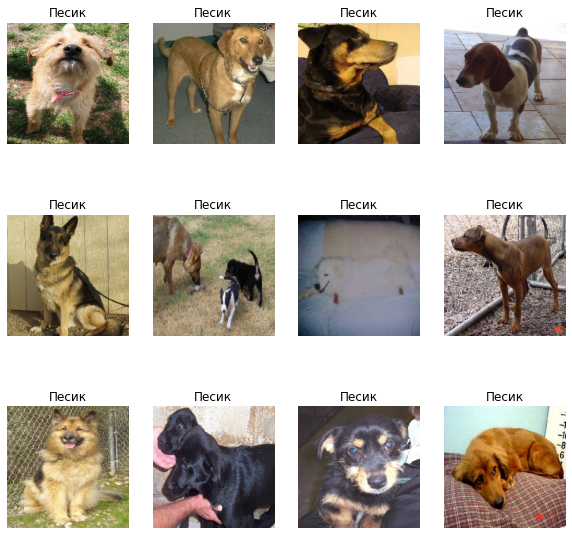

In [100]:
show_result(val_data_gen, 15)

## Создание модели ##
За основу возьмем VGG19 и проведем FineTuning с нашими данными

In [7]:
vgg19 = tf.keras.applications.VGG19(weights = 'imagenet')
vgg19.trainable = False
# проверим размеры взодных картинок
vgg19.inputs

574710816/574710816 [==============================] - 11s 0us/step


[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]

In [8]:
# создадим новую модель и в нее положим все слои кроме последнего
model = tf.keras.models.Sequential()

for L in vgg19.layers[:-1]:
  model.add(L)

# добавим свои слои
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## Обучение модели ##

In [10]:
EPOCHS = 20
history = model.fit_generator(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen)

<ipython-input-10-36b64dc4f598>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen)


Epoch 1/20
16/16 [==============================] - 46s 2s/step - loss: 1.5997 - accuracy: 0.5035 - val_loss: 0.7764 - val_accuracy: 0.5000
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 0.6694 - accuracy: 0.5870 - val_loss: 0.5679 - val_accuracy: 0.7870
Epoch 3/20
16/16 [==============================] - 18s 1s/step - loss: 0.5544 - accuracy: 0.7215 - val_loss: 0.5635 - val_accuracy: 0.6440
Epoch 4/20
16/16 [==============================] - 17s 1s/step - loss: 0.4850 - accuracy: 0.7635 - val_loss: 0.4224 - val_accuracy: 0.8160
Epoch 5/20
16/16 [==============================] - 17s 1s/step - loss: 0.3931 - accuracy: 0.8365 - val_loss: 0.3625 - val_accuracy: 0.8650
Epoch 6/20
16/16 [==============================] - 18s 1s/step - loss: 0.3433 - accuracy: 0.8640 - val_loss: 0.3287 - val_accuracy: 0.8650
Epoch 7/20
16/16 [==============================] - 22s 1s/step - loss: 0.3513 - accuracy: 0.8405 - val_loss: 0.3138 - val_accuracy: 0.8590
Epoch 8/20
16/16 [==

## Инференс ##

In [ ]:
# подключаем google drive
from google.colab import drive
drive.mount('/content/drive')

# Сохранияем модель
model.save('cat_dog_model')
# Импортируем обратно для контрольной проверки
save_model = tf.keras.models.load_model('/content/cat_dog_model')
# Архивируем модель и отправляем на диск
!zip -r /content/drive/MyDrive/cat_dog_classifier_model.zip /content/cat_dog_model

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 0s 30ms/step


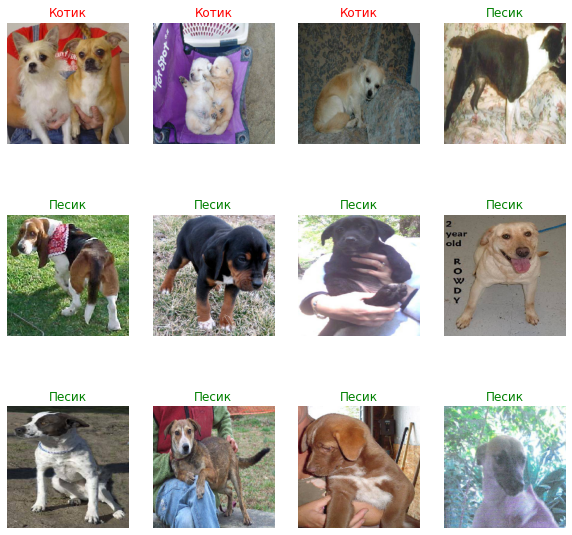

In [105]:
show_result(val_data_gen, 15, predict = True, model = save_model)